In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
from  datetime import datetime

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

reset_graph()

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

## Transfer learning 

Let's tackle the flowers dataset. First, we need to download it:

In [2]:
import sys
import tarfile
from six.moves import urllib
from dataset_utils import _dataset_exists, _get_filenames_and_classes, write_label_file, _convert_dataset
import os.path

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)
fetch_flowers()

In [3]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Let's get the list of all the image file paths for each class:

In [4]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

Let's sort the image paths just to make this notebook behave consistently across multiple runs:

In [5]:
for paths in image_paths.values():
    paths.sort()    

Let's take a peek at the first few images from each class:

roses


(240, 320, 3)


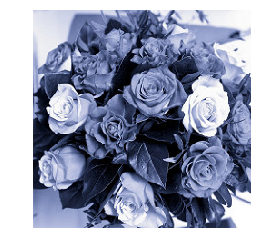

(240, 240, 3)
daisy


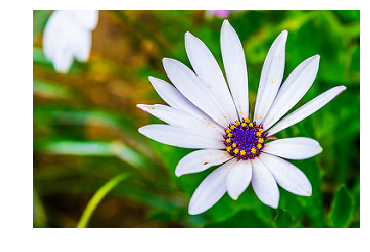

(213, 320, 3)


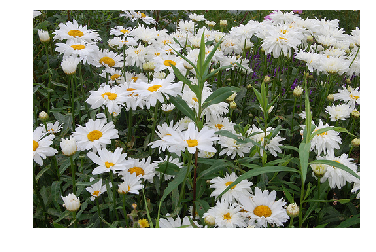

(333, 500, 3)
sunflowers


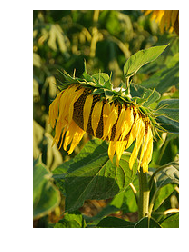

(240, 161, 3)


(212, 320, 3)
tulips


(240, 240, 3)


(333, 500, 3)
dandelion


(240, 320, 3)


(240, 320, 3)


In [6]:
import matplotlib.image as mpimg
import numpy as np

for category, paths in image_paths.items():
    nb_path = len(paths)
    indices = np.random.permutation(nb_path)[0:2]
    print(category)
    for each in indices:
        path = paths[each]
        example_img = mpimg.imread(path)
        plt.imshow(example_img)
        plt.axis("off")
        plt.show()
        print(example_img.shape)

preprocess the images with some data augmentation

In [7]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""
    
    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
    
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, the Convolution Neural Network expects colors represented as
    # 32-bit floats ranging from 0.0 to 1.0:
    return image.astype(np.float32) / 255

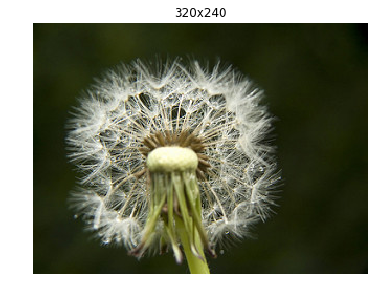

In [8]:
plt.figure(figsize=(6, 8))
plt.imshow(example_img)
plt.title("{}x{}".format(example_img.shape[1], example_img.shape[0]))
plt.axis("off")
plt.show()

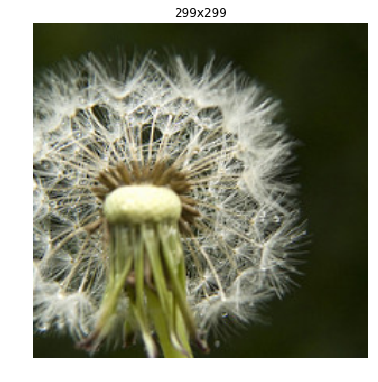

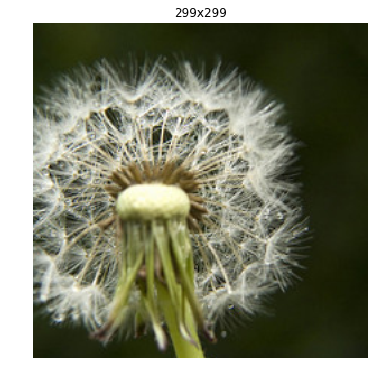

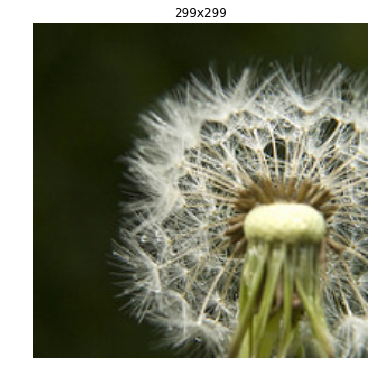

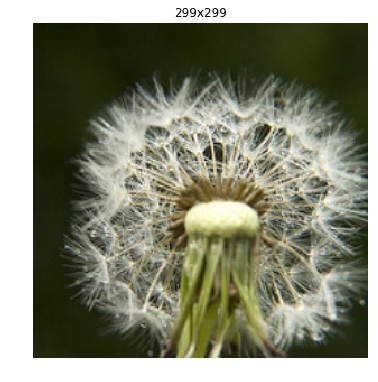

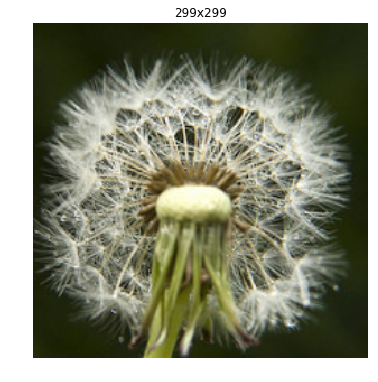

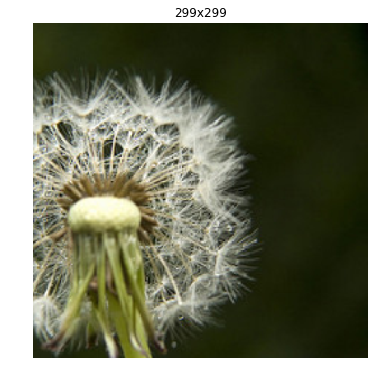

In [10]:
for i in range(10):
    prep_img = prepare_image(example_img)
    plt.figure(figsize=(6, 8))
    plt.imshow(prep_img)
    plt.title("{}x{}".format(prep_img.shape[1], prep_img.shape[0]))
    plt.axis("off")
    plt.show()

In [11]:
flags = tf.app.flags

#State your dataset directory
flags.DEFINE_string('dataset_dir', flowers_root_path, 'String: Your dataset directory')

# Proportion of dataset to be used for evaluation
flags.DEFINE_float('validation_size', 0.3, 'Float: The proportion of examples in the dataset to be used for validation')

# The number of shards to split the dataset into.
flags.DEFINE_integer('num_shards', 2, 'Int: Number of shards to split the TFRecord files into')

# Seed for repeatability.
flags.DEFINE_integer('random_seed', 0, 'Int: Random seed to use for repeatability.')

#Output filename for the naming the TFRecord file
flags.DEFINE_string('tfrecord_filename', None, 'String: The output filename to name your TFRecord file')

FLAGS = flags.FLAGS

In [12]:
photo_filenames, class_names = _get_filenames_and_classes(FLAGS.dataset_dir)  
class_names_to_ids = dict(zip(class_names, range(len(class_names))))

In [14]:
photo_filenames

[]

### 9.3.
Exercise: Using the pretrained Inception v3 model from the previous exercise, freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for your new classification task (e.g., the flowers dataset has five mutually exclusive classes so the output layer must have five neurons and use the softmax activation function).


In [235]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

Now we need to find the point in the graph where we should attach the new output layer. It should be the layer right before the current output layer. One way to do this is to explore the output layer's inputs:

In [236]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

In [237]:
logits.op

<tf.Operation 'InceptionV3/Logits/SpatialSqueeze' type=Squeeze>

In [238]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

In [239]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/convolution:0' shape=(?, 1, 1, 1001) dtype=float32>

In [240]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

Aha! There we are, this is the output of the dropout layer. This is the very last layer before the output layer in the Inception v3 network, so that's the layer we need to build upon. Note that there was actually a simpler way to find this layer: the `inception_v3()` function returns a dict of end points: 

In [241]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the tf.squeeze() function:

In [242]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

In [243]:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

In [244]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("log"):
    filewriter = tf.summary.FileWriter(log_dir("inception"), tf.get_default_graph())
    loss_summary = tf.summary.scalar("loss",loss)
    accuracy_summary = tf.summary.scalar("accuracy",accuracy)
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [245]:
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']

### 9.4.
Exercise: Split your dataset into a training set and a test set. Train the model on the training set and evaluate it on the test set.

In [246]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [247]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

In [248]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

In [249]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = np.stack(prepared_images)
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [250]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

In [251]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [252]:
X_batch.shape

(4, 299, 299, 3)

In [253]:
X_test.shape

(734, 299, 299, 3)

In [254]:
n_epochs = 10
batch_size = 50
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            _, loss_str = sess.run([training_op,loss_summary], feed_dict={X: X_batch, y: y_batch, training: True})
        filewriter.add_summary(loss_str, epoch)

        acc_train, accuracy_str = sess.run([accuracy, accuracy_summary], feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)
        filewriter.add_summary(accuracy_str, epoch)
        save_path = saver.save(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0..........................................................  Train accuracy: 0.54
Epoch 1..........................................................  Train accuracy: 0.68
Epoch 2..........................................................  Train accuracy: 0.64
Epoch 3..........................................................  Train accuracy: 0.64
Epoch 4..........................................................  Train accuracy: 0.62
Epoch 5..........................................................  Train accuracy: 0.7
Epoch 6..........................................................  Train accuracy: 0.6
Epoch 7..........................................................  Train accuracy: 0.68
Epoch 8..........................................................  Train accuracy: 0.66
Epoch 9..........................................................  Train accuracy: 0.68
Computing final accuracy on the test set (t

ResourceExhaustedError: OOM when allocating tensor with shape[734,149,149,32]
	 [[Node: InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_X_0_1/_2357, InceptionV3/Conv2d_1a_3x3/weights/read)]]
	 [[Node: new_output_layer/flower_logits/BiasAdd/_2735 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_4536_new_output_layer/flower_logits/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution', defined at:
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-235-f0e9330d5bbc>", line 9, in <module>
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/contrib/slim/python/slim/nets/inception_v3.py", line 576, in inception_v3
    depth_multiplier=depth_multiplier)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/contrib/slim/python/slim/nets/inception_v3.py", line 111, in inception_v3_base
    net = layers.conv2d(inputs, depth(32), [3, 3], stride=2, scope=end_point)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1027, in convolution
    outputs = layer.apply(inputs)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 503, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 450, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/layers/convolutional.py", line 158, in call
    data_format=utils.convert_data_format(self.data_format, self.rank + 2))
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 672, in convolution
    op=op)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 664, in op
    name=name)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/jfparis/sandbox/handson-ml/env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[734,149,149,32]
	 [[Node: InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_X_0_1/_2357, InceptionV3/Conv2d_1a_3x3/weights/read)]]
	 [[Node: new_output_layer/flower_logits/BiasAdd/_2735 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_4536_new_output_layer/flower_logits/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
